In [2]:
%matplotlib inline


# GMM covariances


Demonstration of several covariances types for Gaussian mixture models.

See :ref:`gmm` for more information on the estimator.

Although GMM are often used for clustering, we can compare the obtained
clusters with the actual classes from the dataset. We initialize the means
of the Gaussians with the means of the classes from the training set to make
this comparison valid.

We plot predicted labels on both training and held out test data using a
variety of GMM covariance types on the iris dataset.
We compare GMMs with spherical, diagonal, full, and tied covariance
matrices in increasing order of performance. Although one would
expect full covariance to perform best in general, it is prone to
overfitting on small datasets and does not generalize well to held out
test data.

On the plots, train data is shown as dots, while test data is shown as
crosses. The iris dataset is four-dimensional. Only the first two
dimensions are shown here, and thus some points are separated in other
dimensions.


/home/adria/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


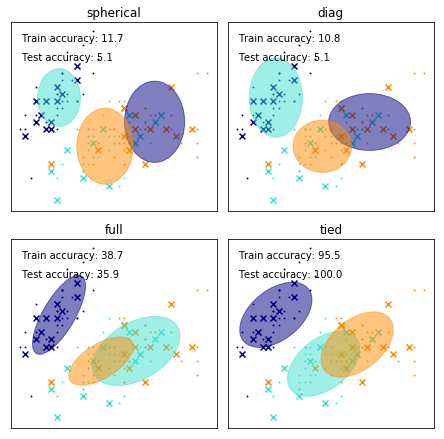

In [2]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ['navy', 'turquoise', 'darkorange', 'green', 'red']*2


def make_ellipses(gmm, ax, i_colors):
    for n, color in i_colors:
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=3,
                   covariance_type=cov_type, max_iter=1000))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)
    Y = estimator.predict(X_test)
    Y_ = estimator.predict(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h, filter(lambda t: np.any(Y==t[0]) or np.any(Y_==t[0]), enumerate(colors)))

    for n, color in enumerate(colors):
        if np.any(Y==n) or np.any(Y_==n):
            data = iris.data[iris.target == n]
            plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color)
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        if len(data) != 0:
            plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

In [4]:
def infinite_gmm_clusters(X, m):
    Y = m.predict(X)
    mask = np.zeros(len(m.weights_), dtype=np.bool)
    for i in set(Y):
        mask[i] = True
    d = {}
    for attr in ['weights', 'means', 'covariances']:
        d[attr] = getattr(m, attr+'_')[mask,...]
    # Proportionally share the weight of the clusters left out
    shared_weight = np.sum(m.weights_[~mask])
    d['weights'] /= (1-shared_weight)
    return d

def samples_from_mixture(m, n):
    "m: model, n: number of samples"
    i = np.random.choice(np.arange(len(m['weights'])), p=m['weights'], size=[n])
    L_covs = np.linalg.cholesky(m['covariances'])[i]
    means = m['means'][i]
    outputs = np.random.randn(*means.shape, 1)
    return means + np.squeeze(np.matmul(L_covs, outputs), axis=2)

def gaussian_pdf(inputs, means, covs):
    """Compute the gaussian PDF for each row of `inputs`, and
    each row of `means` and `covs`."""
    n_features = np.sum(~np.isnan(inputs), axis=1, keepdims=True)
    
    inputs = np.expand_dims(inputs, axis=1)
    diffs = inputs-means
    diffs[np.isnan(diffs)] = 0.0
    right_diffs = np.expand_dims(diffs, axis=3)
    left_diffs = np.expand_dims(diffs, axis=2)
    exponent = left_diffs @ np.linalg.inv(covs) @ right_diffs
    
    exponent = -.5*np.squeeze(exponent, axis=[2,3])
    divider = ((2*np.pi)**n_features * np.linalg.det(covs))**(-.5)
    gaussian_pdf = divider * np.exp(exponent)
    return gaussian_pdf

def mask_matrix(matrix, m1, m2):
    d1 = np.sum(m1)
    d2 = np.sum(m2)
    out = np.empty(shape=[len(matrix), d1, d2])
    j = 0
    for i, b in enumerate(m1):
        if b:
            out[:,j,:] = matrix[:,i,m2]
            j += 1
    return out

def impute(m, inputs, n_impute):
    "Impute inputs using Gaussian Mixture Model m"
    outputs = np.empty(shape=[n_impute]+list(inputs.shape),
                       dtype=np.float)
    for i, inp in enumerate(inputs):
        mask = np.isnan(inp)
        if not np.any(mask):
            outputs[:,i,:] = inp
            continue
        d = {}
        if not np.any(~mask):
            d['means'] = m['means']
            d['covariances'] = m['covariances']
            d['weights'] = m['weights']
        else:
            g_pdf = gaussian_pdf([inp], m['means'], m['covariances'])
            # $\tau$ in "Imputation through finite Gaussian mixture models" (Di Zio et al., 2007)
            point_provenance = m['weights']*g_pdf
            point_provenance /= np.sum(point_provenance, axis=1, keepdims=True)
    
            K_12 = mask_matrix(m['covariances'],mask,~mask)
            K_22__1 = np.linalg.inv(mask_matrix(m['covariances'],~mask,~mask))
            K_1222 = K_12 @ K_22__1
            K_21 = mask_matrix(m['covariances'],~mask,mask)
            K_11 = mask_matrix(m['covariances'],mask,mask)

            diff = np.expand_dims(inp[~mask] - m['means'][:,~mask], axis=2)
            d['means'] = m['means'][:,mask] + np.squeeze(K_1222 @ diff, axis=2)
            d['covariances'] = K_11 - K_1222 @ K_21
            d['weights'] = point_provenance[0,:]
            
            outputs[:,i,~mask] = inp[~mask]
        outputs[:,i,mask] = samples_from_mixture(d, n_impute)
    return outputs

def rmse_sum(mask_missing, original_df, multiple_imputed_df):
    assert original_df.shape == multiple_imputed_df[0].shape, "data set shape not matching"
    sq_diff = (original_df-multiple_imputed_df)**2
    mse = np.sum(sq_diff*mask_missing)/(len(multiple_imputed_df)*np.sum(mask_missing))
    return mse**.5


In [8]:
import utils
import imp
imp.reload(utils)
# Learn input distribution
est = BayesianGaussianMixture(n_components=10, covariance_type='full', max_iter=1000)
X_missing = utils.mcar_total(X_train)
est.fit(X_missing)
m = infinite_gmm_clusters(X_train, est)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [230]:
est2 = GaussianMixture(n_components=3, covariance_type='full', max_iter=1000)
est2.fit(X_train)
m2 = infinite_gmm_clusters(X_train, est2)

(1000, 4)


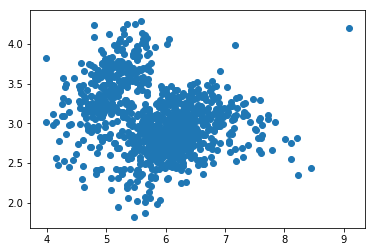

In [232]:
# Validate input distribution visually
s = samples_from_mixture(m, 1000)
print(s.shape)

plt.figure()
plt.scatter(s[:,0], s[:,1])
plt.show()

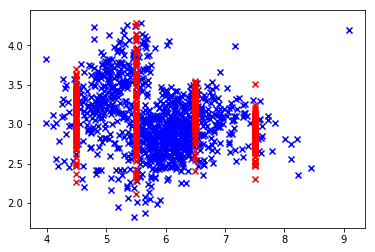

In [234]:
# Validate code working visually
conditional = np.array([[5.5,np.nan,np.nan,np.nan],
                        [4.5,np.nan,np.nan,np.nan],
                        [6.5,np.nan,np.nan,np.nan],
                        [7.5,np.nan,np.nan,np.nan]])
c_s = impute(m, conditional, 100)
plt.figure()
plt.scatter(s[:,0], s[:,1], color='b', marker='x')
c_s = np.reshape(c_s, [-1, c_s.shape[-1]])
plt.scatter(c_s[:,0], c_s[:,1], color='r', marker='x')
plt.show()

In [258]:
mask_missing = np.random.rand(*X_train.shape) < 0.2
original = X_train.copy()
original[mask_missing] = np.nan

original2 = impute(m, X_train, 1)
print(rmse_sum(mask_missing, X_train, original2))

restored = impute(m, original, 5)
print(rmse_sum(mask_missing, X_train, restored))
print(rmse_sum(mask_missing, X_train, np.mean(restored, axis=0, keepdims=True)))

0.0
0.425873160771
0.336146210384


In [243]:
restored = impute(m2, original, 5)
print(rmse_sum(mask_missing, X_train, restored))
print(rmse_sum(mask_missing, X_train, np.mean(restored, axis=0, keepdims=True)))

0.368674661784
0.292598529683


In [210]:
%load_ext rpy2.ipython

In [211]:
import pandas as pd
import numpy as np
import pickle_utils as pu
%R library("ggplot2")
%R install.packages("mice")
%R library("mice")
%R install.packages("lattice")
%R library("lattice")
%R install.packages("VIM")
%R library("VIM")
%R install.packages("missForest")
%R library("missForest")
%R install.packages("doParallel")
%R library("doParallel")
%R install.packages("foreach")
%R library("foreach")

from rpy2.ipython.rmagic import converter

NUMBER_IMPUTATIONS = 50

/home/adria/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Want to understand how all the pieces fit together? Buy the ggplot2
book: http://ggplot2.org/book/

  warnings.warn(x, RRuntimeWarning)
/home/adria/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Installing package into ‘/home/adria/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/home/adria/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: trying URL 'https://mirror.las.iastate.edu/CRAN/src/contrib/mice_2.30.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/adria/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/home/adria/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  length 648634 bytes (633 KB)

  warnings.warn(x, RRuntimeWarning)
/h

In [215]:
%R registerDoParallel(makeCluster(8))
missing_df = pd.DataFrame(original)

In [226]:
%%R -i missing_df -i NUMBER_IMPUTATIONS -o r_datasets -o mf_imp
# Impute using MICE
imputed_object <- mice(missing_df, m=NUMBER_IMPUTATIONS, maxit=500, meth='pmm', seed=500)
r_datasets = lapply(1:NUMBER_IMPUTATIONS, function(v) return(complete(imputed_object, v)))
mf_imp <- missForest(missing_df)$ximp


 iter imp variable
  1   1  X0  X1  X2  X3
  1   2  X0  X1  X2  X3
  1   3  X0  X1  X2  X3
  1   4  X0  X1  X2  X3
  1   5  X0  X1  X2  X3
  2   1  X0  X1  X2  X3
  2   2  X0  X1  X2  X3
  2   3  X0  X1  X2  X3
  2   4  X0  X1  X2  X3
  2   5  X0  X1  X2  X3
  3   1  X0  X1  X2  X3
  3   2  X0  X1  X2  X3
  3   3  X0  X1  X2  X3
  3   4  X0  X1  X2  X3
  3   5  X0  X1  X2  X3
  4   1  X0  X1  X2  X3
  4   2  X0  X1  X2  X3
  4   3  X0  X1  X2  X3
  4   4  X0  X1  X2  X3
  4   5  X0  X1  X2  X3
  5   1  X0  X1  X2  X3
  5   2  X0  X1  X2  X3
  5   3  X0  X1  X2  X3
  5   4  X0  X1  X2  X3
  5   5  X0  X1  X2  X3
  6   1  X0  X1  X2  X3
  6   2  X0  X1  X2  X3
  6   3  X0  X1  X2  X3
  6   4  X0  X1  X2  X3
  6   5  X0  X1  X2  X3
  7   1  X0  X1  X2  X3
  7   2  X0  X1  X2  X3
  7   3  X0  X1  X2  X3
  7   4  X0  X1  X2  X3
  7   5  X0  X1  X2  X3
  8   1  X0  X1  X2  X3
  8   2  X0  X1  X2  X3
  8   3  X0  X1  X2  X3
  8   4  X0  X1  X2  X3
  8   5  X0  X1  X2  X3
  9   1  X0  X1  X2 

In [261]:
mice_imputed_data_df = list(converter.ri2py(df) for df in r_datasets)
print("MICE", rmse_sum(mask_missing, X_train, np.mean(list(d.values for d in mice_imputed_data_df), axis=0, keepdims=True)))
print("MissForest", rmse_sum(mask_missing, X_train, [mf_imp.values]))

MICE 0.143535197569
MissForest 0.13052373738
